In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

In [2]:
# Load dataset
df = pd.read_csv('data/ts2024.csv', parse_dates=['DateTime'])

# Display initial info
print("Initial dataset info:")
print(df.info())
print(df.describe())

Initial dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  17544 non-null  object 
 1   Date      17544 non-null  object 
 2   Hour      17544 non-null  int64  
 3   X         16800 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 548.4+ KB
None
               Hour             X
count  17544.000000  16800.000000
mean      11.500000      0.046320
std        6.922384      0.048945
min        0.000000      0.000000
25%        5.750000      0.018200
50%       11.500000      0.036800
75%       17.250000      0.053800
max       23.000000      0.450000


In [3]:
# Check for missing and zero values
missing = df.isna().sum()
zeros = (df['X'] == 0).sum()
print(f"Missing values:\n{missing}")
print(f"Zero values in 'X': {zeros}")

Missing values:
DateTime      0
Date          0
Hour          0
X           744
dtype: int64
Zero values in 'X': 107


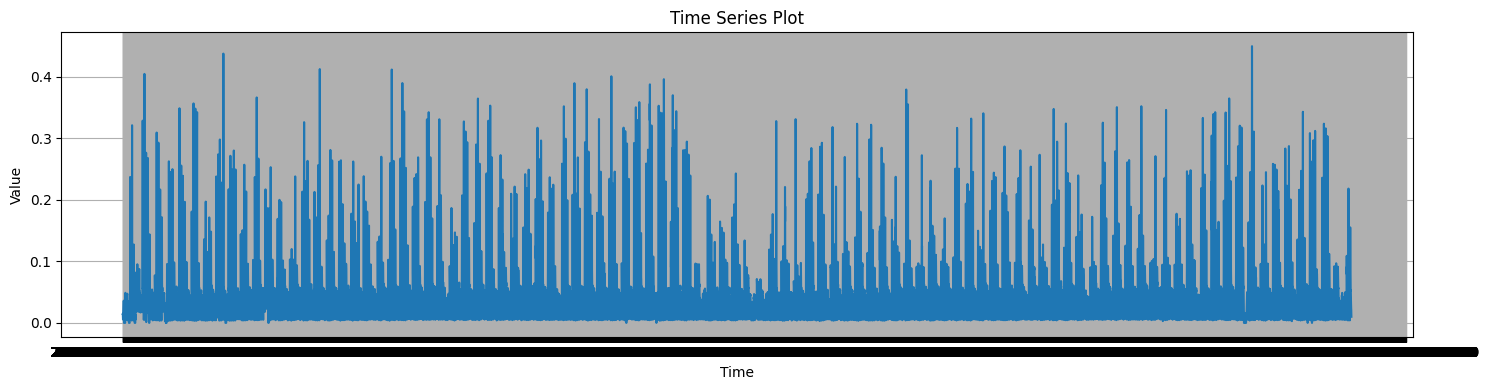

In [4]:
# Plot the time series
plt.figure(figsize=(15, 4))
plt.plot(df['DateTime'], df['X'])
plt.title("Time Series Plot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Replace zero values with 24-hour median
def replace_zeros_with_moving_median(series, window=24):
    zero_indices = series[series == 0].index
    for idx in zero_indices:
        left = max(0, idx - window // 2)
        right = min(len(series), idx + window // 2)
        median_val = series[left:right].median()
        series.at[idx] = median_val
    return series

df['X'] = replace_zeros_with_moving_median(df['X'])

In [6]:
# Handle outliers: replace > 99th percentile with median
threshold = df['X'].quantile(0.99)
df.loc[df['X'] > threshold, 'X'] = df['X'].median()

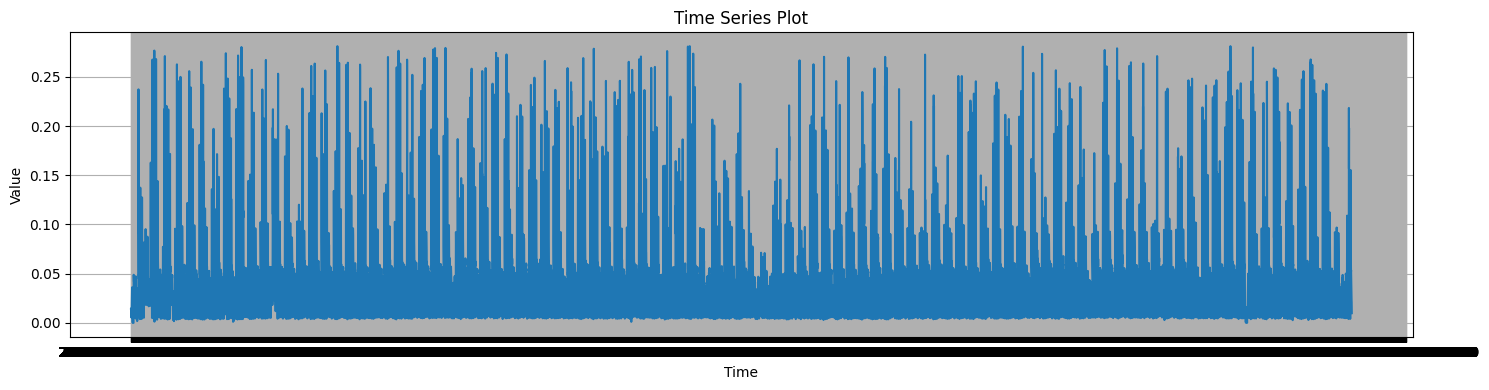

In [7]:
# Plot the time series
plt.figure(figsize=(15, 4))
plt.plot(df['DateTime'], df['X'])
plt.title("Time Series Plot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Split into 24 hourly series
hourly_series = {h: df[df['Hour'] == h]['X'].reset_index(drop=True) for h in range(24)}

In [15]:
for h, series in hourly_series.items():
    clean_series = series.dropna()
    clean_series = clean_series[clean_series > 0]  # Keep only strictly positive

    if len(clean_series) < 3:
        print(f"Hour {h} skipped due to insufficient valid data.")
        continue

    transformed, lmbda = boxcox(clean_series)
    lambdas[h] = lmbda

    adf_stat, p_val, _, _, critical_vals, _ = adfuller(transformed)
    stationary_results[h] = {
        'ADF Statistic': adf_stat,
        'p-value': p_val,
        'Is Stationary': adf_stat < critical_vals['5%']
    }

In [16]:
# Summarize stationarity
print("Box-Cox Lambdas:")
print(lambdas)
print("\nADF Stationarity Test Results:")
for hour, result in stationary_results.items():
    print(f"Hour {hour}: {result}")

Box-Cox Lambdas:
{0: 0.22313616531953798, 1: 0.12932881688747733, 2: 0.1285045527071851, 3: 0.1896450230771628, 4: 0.421080272451604, 5: 1.035137953720682, 6: 0.6048955117420787, 7: 0.3329262559250717, 8: 0.2010355748988227, 9: 0.18936574692572966, 10: 0.3656823492547146, 11: 3.072003596160122, 12: 3.1148406243843336, 13: 2.2616228095468456, 14: 0.914524280971563, 15: 0.6952343187955952, 16: 0.7438802519782757, 17: 1.1917474001118624, 18: 0.8220804702473448, 19: 1.3092766545429837, 20: 1.1512901701190763, 21: 0.9505279709802898, 22: 0.8171787643351116, 23: 0.5367864168203881}

ADF Stationarity Test Results:
Hour 0: {'ADF Statistic': -3.8547388915193794, 'p-value': 0.0023943805725755553, 'Is Stationary': True}
Hour 1: {'ADF Statistic': -5.471255174143093, 'p-value': 2.395877887670473e-06, 'Is Stationary': True}
Hour 2: {'ADF Statistic': -5.47826418132824, 'p-value': 2.3152403196821374e-06, 'Is Stationary': True}
Hour 3: {'ADF Statistic': -4.257855467612504, 'p-value': 0.0005250839867772

In [17]:
# Save processed data
df.to_csv("preprocessed_time_series.csv", index=False)